# Analysis of  StarTracker Pointing - Repeatability 

Full test description at: https://sitcomtn-063.lsst.io/

In this notebook, we quantify the telescope jitter after settle to a coordinate.

For this:
1. We compute the standard deviation of $\delta ra \text{, } \delta dec$
2. Does the jitter depends on $ra, dec$?

To visualize this correlations see: \
`LVV-T2732_analysis.ipynb`

In [401]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [402]:
# function to read in the metadata that has been downloaded
import pandas as pd
def read_rubintv(fname):
    df = pd.read_json(fname).T
    df = df.dropna()
    times = df[['UTC','UTC wide']]
    
    df = df.drop(columns=['UTC','UTC wide'])
    df = df.astype(float)
    
    # set time vectors
    timenew = (today+'T'+ times['UTC'].to_numpy()).astype(np.datetime64)
    timenew2= (today+'T'+ times['UTC wide'].to_numpy()).astype(np.datetime64)
    
    df['UTC'] = pd.Series(timenew, index=df.index)
    df['UTC wide'] = pd.Series(timenew2, index=df.index)
    df['seq_num'] = df.index
    
    return df

In [403]:
def get_groups(df):
    ra = df['Calculated Ra wide'].to_numpy()
    dec = df['Calculated Dec wide'].to_numpy()

    groups = np.zeros(ra.size, dtype=int)
    diffRa = np.diff(ra)
    diffDec = np.diff(dec)
    dPnt = np.hypot(diffDec, diffRa)
    
    counter = 0
    for i in range(diffRa.size):
        if  (dPnt[i]>1/60): counter += 1    
        groups[i+1] = counter

    df['groups'] = groups
    print('Number of Groups:%i'%np.unique(groups).size)
    return df

In [404]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y):
    isnan = np.isnan(x)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return np.append(coefs, np.sqrt(cov[1,1]))

def get_residual(df,col1='Calculated Ra wide',col2='Calculated Dec wide'):
    groups = df['groups'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df[col1].to_numpy()
    dec = df[col2].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    for ix in keys:
        #base_ra[ix] = ra[ix][0]
        #base_dec[ix] = dec[ix][0]
        
        base_ra[ix] = np.nanmean(ra[ix])
        base_dec[ix] = np.nanmean(dec[ix])
    
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600
    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    
    return res_ra, res_dec, base_ra, base_dec

## First Night: 9th March

In [405]:
# read in dataframe
today = '2023-03-09'
fname = 'startracker_%s.json'%today
df = read_rubintv(fname)

In [406]:
sequences = [ [600,646],  [646,946],  [949,982], [983,1115]]
# sequences = [ [600,643] ]
# sequences = [ [679,712] ]
# sequences = [ [600,646],  [646,910]]
indices = np.empty((0,),dtype=int)

for i0, ie in sequences:
    indices = np.append(indices, np.arange(i0,ie,1,dtype=int))
indices[::5]

array([ 600,  605,  610,  615,  620,  625,  630,  635,  640,  645,  650,
        655,  660,  665,  670,  675,  680,  685,  690,  695,  700,  705,
        710,  715,  720,  725,  730,  735,  740,  745,  750,  755,  760,
        765,  770,  775,  780,  785,  790,  795,  800,  805,  810,  815,
        820,  825,  830,  835,  840,  845,  850,  855,  860,  865,  870,
        875,  880,  885,  890,  895,  900,  905,  910,  915,  920,  925,
        930,  935,  940,  945,  953,  958,  963,  968,  973,  978,  984,
        989,  994,  999, 1004, 1009, 1014, 1019, 1024, 1029, 1034, 1039,
       1044, 1049, 1054, 1059, 1064, 1069, 1074, 1079, 1084, 1089, 1094,
       1099, 1104, 1109, 1114])

In [407]:
# selection of the sequences
data = df.iloc[indices].reset_index() 
print(('Positions for ' + str(data.seq_num.iloc[0]) + ' to ' + str(data.seq_num.iloc[-1])))
first_attempt_circle = get_groups(data)

Positions for 621 to 1137
Number of Groups:166


In [408]:
# check groups
# each group should have 3 exposures
_, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
counts

array([4, 4, 4, 3, 4, 4, 4, 3, 4, 4, 8, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [409]:
gids, _, counts = np.unique(data['groups'].to_numpy(), return_index=True, return_counts=True)
is_group = counts<=4
ngroups = np.count_nonzero(is_group)
print('Number of Groups w/ 3 exposures: %i'%ngroups)

# filter
mask = np.in1d(data['groups'].to_numpy(), gids[is_group])
data = data.iloc[mask].copy()

Number of Groups w/ 3 exposures: 165


### Find Snakes: Clustering Algorithm

In [410]:
from scipy.cluster.vq import whiten, kmeans, vq, kmeans2

nsnakes = int(np.unique(data['groups']).size/11)
pos = np.vstack([data['Calculated Ra wide'].to_numpy(),data['Calculated Dec wide'].to_numpy()]).T

# get cluster centers
centroids, mean_value = kmeans(pos, nsnakes)
ix = np.argsort(centroids[:,0])

# mapping the centroids
clusters, distances = vq(pos, centroids[ix,:])

# saving snakes to the dataframe
data['snakes'] = clusters

print("Cluster index :", clusters, "\n")

Cluster index : [ 7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
  7  7  7  7  7  7  7  7  7  7  7  7  7  7  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  0  0  0  1  1  1  1  1  1  1  1  1  0  0  0  1  1  1  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4
  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  4  4  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5  5
  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9
  9  9  9  9  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 1

In [411]:
res_ra, res_dec, base_ra, base_dec = get_residual(data)

snakes = data['snakes'].to_numpy()
keys = [np.where(snakes==gi)[0] for gi in np.unique(snakes)]
keys[0]

array([53, 54, 55, 65, 66, 67])

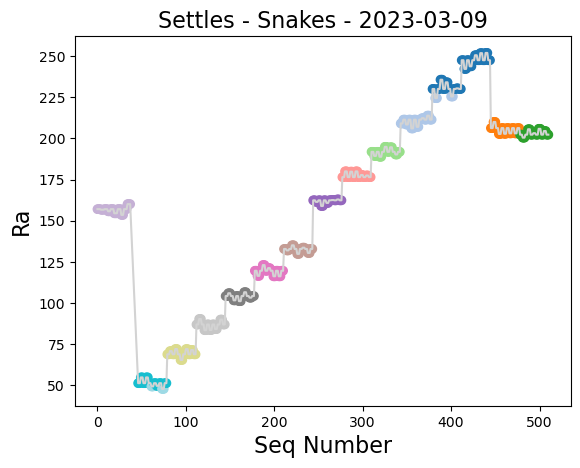

In [412]:
# snake_id = 26
# ix = keys[snake_id]
ix = np.arange(0,len(data),1)
data['Calculated Ra wide'].iloc[ix].plot(color='lightgray')
plt.scatter(data.iloc[ix].index, data['Calculated Ra wide'].iloc[ix], 
            c=data['snakes'].iloc[ix], cmap='tab20_r')

plt.title('Settles - Snakes - %s'%today, fontsize=16)
plt.ylabel('Ra', fontsize=16)
plt.xlabel('Seq Number', fontsize=16)
plt.savefig('figures/pointing_ra_%s.png'%today,dpi=100)

For each group (setlle point), I subtract the median (RA,DEC). The residuals are basically the telescope jitter.

In [413]:
base_alt = data['Calculated Alt wide'].to_numpy()
base_az = data['Calculated Az wide'].to_numpy()
snakes = data['snakes'].to_numpy()

# base_az = np.where(base_az>180, 180-base_az, base_az)
# base_ra = np.where(base_ra>180, 180-base_ra, base_ra)

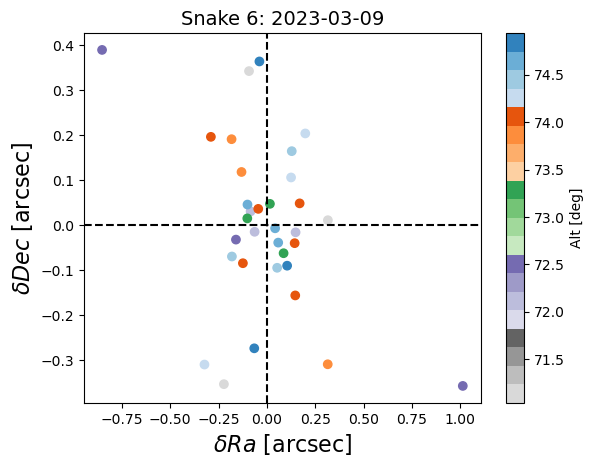

In [414]:
snake_id = 6
ix = keys[snake_id]
plt.scatter(res_ra[ix], res_dec[ix], c=base_alt[ix],cmap='tab20c_r')
plt.axvline(0,color='k',ls='--')
plt.axhline(0,color='k',ls='--')
plt.title('Snake %i: %s'%(snake_id,today), fontsize=14)
plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
plt.colorbar(label='Alt [deg]')
plt.savefig('figures/residual_radec_snake%i_%s.png'%(snake_id, today),dpi=100)

We see a typical jitter amplitude of $0.5$ arcsec with some outliers.

In [415]:
def get_sigma_68(x):
    p16, p84 = np.nanpercentile(x, [16,84])
    return (p84-p16)/2.

def get_jitter(ra,dec):
    jra = get_sigma_68(ra)
    jdec = get_sigma_68(dec)
    return np.array([jra, jdec, np.hypot(jra,jdec)])

In [416]:
# Now I will compute the standard deviation (\sigma_{68}) for each snake

stds = []
for ix in keys:
    stds.append(get_jitter(res_ra[ix],res_dec[ix]))
stds = np.array(stds)

In [417]:
_, sids, counts = np.unique(data['snakes'].to_numpy(), return_index=True, return_counts=True)
counts

array([ 6, 27, 33, 33, 33, 33, 33, 38, 33, 33, 33, 33, 33, 42, 60])

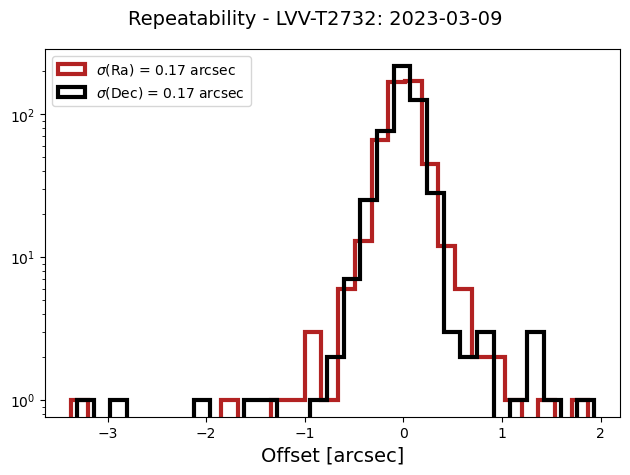

In [418]:
jra = get_sigma_68(res_ra)
jdec = get_sigma_68(res_dec)

_ = plt.hist(res_ra, bins=31, color='firebrick', histtype='step', lw=3, label='$\sigma$(Ra) = %.2f arcsec'%jra)
_ = plt.hist(res_dec, bins=31, color='k', histtype='step', lw=3, label='$\sigma$(Dec) = %.2f arcsec'%jdec)
plt.yscale('log')
plt.legend(loc=2)
plt.xlabel('Offset [arcsec]', fontsize=14)
plt.suptitle('Repeatability - LVV-T2732: %s'%today,fontsize=14)
plt.tight_layout()
plt.savefig('figures/radec_residual_histogram_%s.png'%today,dpi=100)

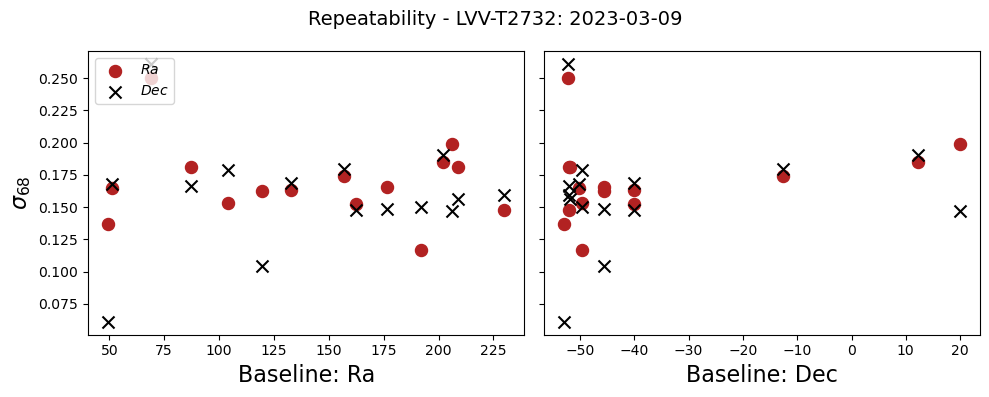

In [419]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax1.scatter(base_ra[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_dec[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_ra[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_dec[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=2)
# ax1.errorbar(base_ra[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')
# ax2.errorbar(base_dec[sids], stds[:,1], fmt='o', yerr=coefs[:,2], color='lightgray')

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Ra',fontsize=16)
ax2.set_xlabel('Baseline: Dec',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: 2023-03-09',fontsize=14)
fig.tight_layout()

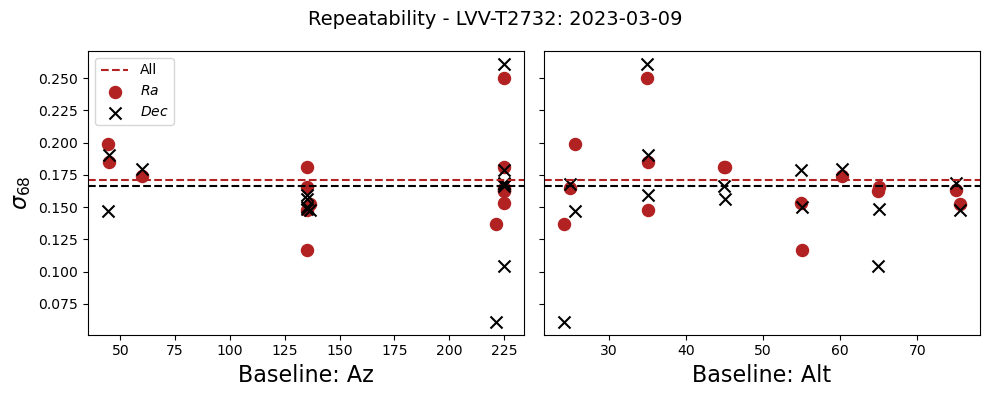

In [420]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)
ax2.axhline(jra, c='firebrick', ls='--')
ax2.axhline(jdec, c='k', ls='--')

ax1.axhline(jra, c='firebrick', ls='--',label='All')
ax1.axhline(jdec, c='k', ls='--')

ax1.scatter(base_az[sids], stds[:,0], c='firebrick', s=75, label=r'$Ra$')
ax2.scatter(base_alt[sids], stds[:,0], c='firebrick', s=75)

ax1.scatter(base_az[sids], stds[:,1], c='k', marker='x', s=75, label=r'$Dec$')
ax2.scatter(base_alt[sids], stds[:,1], c='k', marker='x', s=75)

ax1.legend(loc=0)
# ax2.legend(loc=1)

ax1.set_ylabel('$\sigma_{68}$',fontsize=16)
ax1.set_xlabel('Baseline: Az',fontsize=16)
ax2.set_xlabel('Baseline: Alt',fontsize=16)
fig.suptitle('Repeatability - LVV-T2732: %s'%today,fontsize=14)
fig.tight_layout()
plt.savefig('figures/scatter_radec_azalt_%s.png'%today,dpi=100)

## Save Output

In [421]:
res_az, res_alt, base_az, base_alt = get_residual(data,
                                                  col1='Calculated Alt wide', 
                                                  col2='Calculated Alt wide')

In [422]:
# save output
myvars = res_ra, res_dec, res_az, res_alt, base_ra, base_dec, base_az, base_alt, snakes
cols = ['Res ra', 'Res dec', 'Res az', 'Res alt','Base Ra', 'Base Dec', 'Base Az', 'Base Alt', 'Snakes']
mydict = dict().fromkeys(cols)
for i,col in enumerate(cols):
    mydict[col] = myvars[i]

In [423]:
out = pd.DataFrame(mydict)
out.to_csv('tmp/repeatability_%s.csv'%today)

## Pointing Model

The variance of the ra,dec residuals can be due to the pointing model. Although only three images were taken, the 
stars motion during 15 sec is larger than $0.1$ arcsec. We will verify the offset introduced by the uncertainty of the pointing model.

### Residuals

The central target of the circle was observed 6 times at different times. 
So, the effect due to the pointing model is the largest. 


We define our baseline as the first measured RA,DEC on the central point. 

In [542]:
def get_residual2(df,col1='Calculated Ra wide',col2='Calculated Dec wide'):
    groups = df['snakes'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]
    ra = df[col1].to_numpy()
    dec = df[col2].to_numpy()

    base_ra = np.zeros_like(ra)
    base_dec = np.zeros_like(dec)
    
    for ix in keys:
        base_ra[ix] = ra[ix][0]
        base_dec[ix] = dec[ix][0]
        
    res_ra = (ra-base_ra)*3600*np.cos(base_dec*np.pi/180)
    res_dec = (dec-base_dec)*3600    
    filter_nan = np.hypot(res_ra, res_dec) > 30. #get_outliers(res_ra)
    res_ra[filter_nan] = np.nan
    res_dec[filter_nan] = np.nan
    return res_ra, res_dec, base_ra, base_dec

In [543]:
res_ra, res_dec, base_ra, base_dec = get_residual2(data)

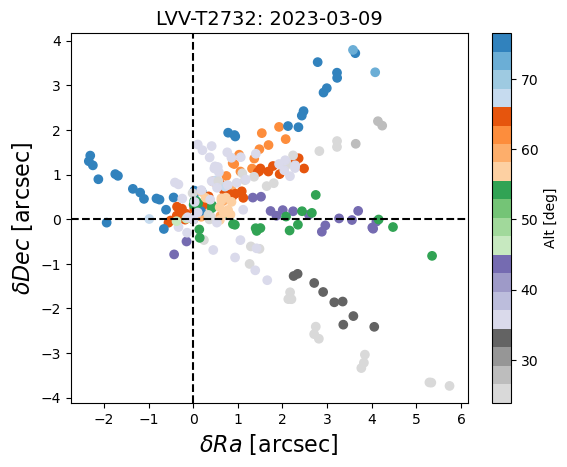

In [544]:
# sel = (data['index'] >= 600) &(data['index'] <= 1600)
# plt.scatter(res_ra[sel], res_dec[sel], c=base_alt[sel],cmap='tab20c_r')
plt.scatter(res_ra, res_dec, c=base_alt,cmap='tab20c_r')
plt.axvline(0,color='k',ls='--')
plt.axhline(0,color='k',ls='--')
plt.title('LVV-T2732: 2023-03-09',fontsize=14)
plt.xlabel(r'$\delta Ra$ [arcsec]',fontsize=16)
plt.ylabel(r'$\delta Dec$ [arcsec]',fontsize=16)
plt.colorbar(label='Alt [deg]')
plt.savefig('residual_radec.png',dpi=100)

In [545]:
def get_baseline(ycol, df=data):
    groups = df['snakes'].to_numpy()
    keys = [np.where(groups==gi)[0] for gi in groups]

    yvec = df[ycol].to_numpy()
    base = np.zeros_like(yvec)
    for ix in keys:
        base[ix] = yvec[ix][0]
    return base

In [546]:
base_utc = get_baseline('UTC')
dT = (data['UTC'] - base_utc).to_numpy().astype('timedelta64[s]').astype(np.int32)

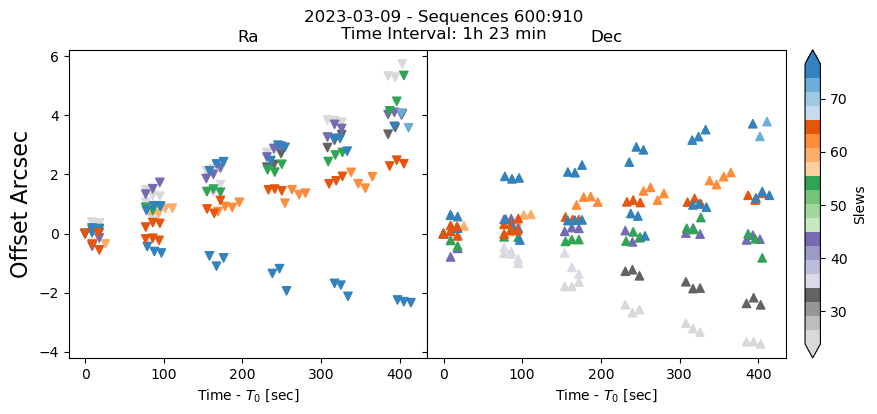

In [547]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

sel = (data['index'] >= 1) &(data['index'] <= 910)
tt = (np.max(data.UTC[sel])-np.min(data.UTC[sel]))
tlabel = 'Time Interval: %ih %i min'%(tt.components.hours, tt.components.minutes)
title = '%s - Sequences 600:910\n'%today+tlabel

im = ax1.scatter(dT[sel], res_ra[sel], marker='v', c=base_alt[sel], cmap='tab20c_r', label='Ra')
ax2.scatter(dT[sel], res_dec[sel], marker='^', c=base_alt[sel], cmap='tab20c_r', label='Dec')

ax1.set_title('Ra')
ax2.set_title('Dec')
ax1.set_ylabel('Offset Arcsec', fontsize=16)
ax1.set_xlabel('Time - $T_0$ [sec]')
ax2.set_xlabel('Time - $T_0$ [sec]')
fig.suptitle(title)
cb = fig.colorbar(im, label='Alt', ax=[ax1,ax2], location='right', fraction=0.05, pad=0.025, extend='both')
fig.savefig('figures/offset_rate_%s.png'%today, dpi=100)

### Offset Rate

The offset is linear with time. So, the offset rate is simply the slope of this linear relation. 

In [555]:
from scipy.optimize import curve_fit
def linear(x,a,b):
    return a+b*x

def get_slope(x,y, niter=3):
    isnan = np.isnan(y)
    coefs, cov = curve_fit(linear, x[~isnan], y[~isnan])
    return coefs


In [549]:
groups = data['snakes'].to_numpy()
keys = [np.where(groups==gi)[0] for gi in np.unique(groups)]
    
rate1, rate2 = [], []
for ix in keys:
    rate1.append(get_slope(dT[ix], res_ra[ix]))
    rate2.append(get_slope(dT[ix], res_dec[ix]))
rate1 = np.array(rate1)
rate2 = np.array(rate2)

Text(0.5, 0, 'Offset Rate [arcsec/min]')

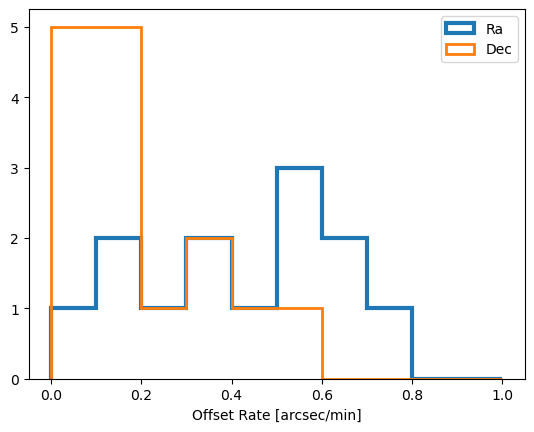

In [550]:
mybins = np.arange(0., 1.1, 0.1)
plt.hist(60*np.abs(rate1)[:,1], bins=mybins, label='Ra', histtype='step', lw=3)
plt.hist(60*np.abs(rate2)[:,1], bins=mybins, label='Dec', histtype='step', lw=2)
# plt.hist(60*coefs[:,2], bins=mybins, label='Norm', histtype='step', lw=3)
plt.legend()
plt.xlabel('Offset Rate [arcsec/min]')

Text(0, 0.5, 'Az')

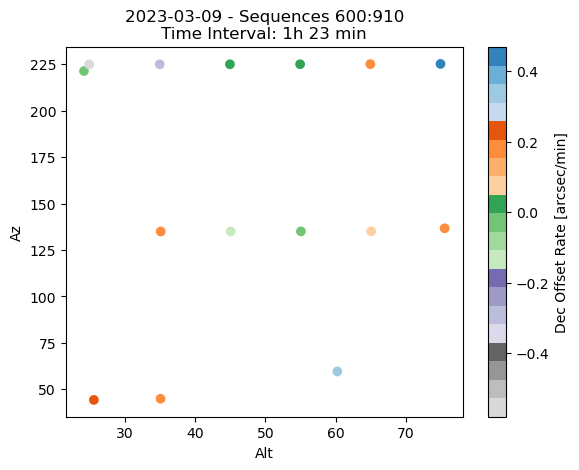

In [551]:
base_alt = data['Calculated Alt wide'].to_numpy()
base_az = data['Calculated Az wide'].to_numpy()
gs, gids, counts = np.unique(groups, return_index=True, return_counts=True)

plt.scatter(base_alt[gids], base_az[gids], c=60*rate2[:,1], cmap='tab20c_r')
plt.colorbar(label='Dec Offset Rate [arcsec/min]')
plt.title(title)
plt.xlabel('Alt')
plt.ylabel('Az')

### Corrections

We can correct for this effect and actually measure the pertubations of the telescope.

In [552]:
res_ra_c = res_ra
res_dec_c = res_dec
for i, ix in enumerate(keys):
    res_ra_c[ix] -= linear(dT[ix], *rate1[i])
    res_dec_c[ix] -= linear(dT[ix], *rate2[i])

In [556]:
def mask_outliers(x, n=3.0):
    q1,mean,q3 = np.nanpercentile(x, [16,50,84])
    iqr = (q3-q1)/2.
    plow= q1-n*iqr
    phig= q3+n*iqr
    x = np.where((x>phig)|(x<plow),np.nan,x)
    return x

In [572]:
res_ra_c = mask_outliers(res_ra_c)
res_dec_c = mask_outliers(res_dec_c)

std_ra = np.nanstd(res_ra_c)
std_dec = np.nanstd(res_dec_c)
print('RMS - After Pointing Model Correction')
print('Ra: %.2f arcsec'%std_ra)
print('Dec: %.2f arcsec'%std_dec)

RMS - After Pointing Model Correction
Ra: 0.26 arcsec
Dec: 0.22 arcsec


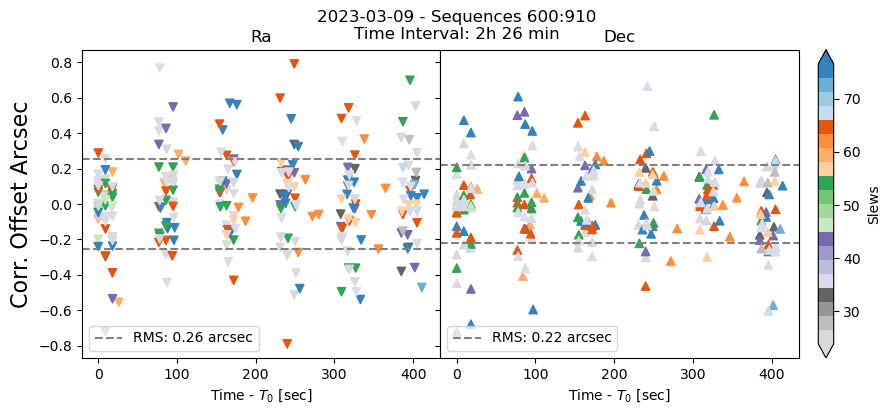

In [579]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), sharey='all')
fig.subplots_adjust(wspace=0.)

sel = (data['index'] >= 100) &(data['index'] <= 2000)
tt = (np.max(data.UTC[sel])-np.min(data.UTC[sel]))
tlabel = 'Time Interval: %ih %i min'%(tt.components.hours, tt.components.minutes)
title = '%s - Sequences 600:910\n'%today+tlabel

im = ax1.scatter(dT[sel], res_ra_c[sel], marker='v', c=base_alt[sel], cmap='tab20c_r')
ax2.scatter(dT[sel], res_dec_c[sel], marker='^', c=base_alt[sel], cmap='tab20c_r')
ax1.axhline(std_ra, ls='--', color='gray',label='RMS: %.2f arcsec'%std_ra)
ax2.axhline(std_dec, ls='--', color='gray',label='RMS: %.2f arcsec'%std_dec)
ax1.axhline(-std_ra, ls='--', color='gray')
ax2.axhline(-std_dec, ls='--', color='gray')
ax1.legend(loc=3)
ax2.legend(loc=3)
ax1.set_title('Ra')
ax2.set_title('Dec')
ax1.set_ylabel('Corr. Offset Arcsec', fontsize=16)
ax1.set_xlabel('Time - $T_0$ [sec]')
ax2.set_xlabel('Time - $T_0$ [sec]')
fig.suptitle(title)
cb = fig.colorbar(im, label='Slews', ax=[ax1,ax2], location='right', fraction=0.05, pad=0.025, extend='both')
fig.savefig('figures/corrected_offset_rate_%s.png'%today, dpi=100)

Even after correction, we see a residual precision of 0.26 arcsec. This is result is equivalent to the one using the three images in a row, given the correction uncertainities. 